In [1]:
import numpy as np
import pandas as pd

def f(x1, x2):
    return (1.3356 * (1.5 * (1 - x1)) 
            + np.exp((2 * x1) - 1) * np.sin((3 * np.pi) * ((x1 - 0.6) ** 2))
            + np.exp(3 * (x2 - 0.5)) * np.sin((4 * np.pi) * ((x2 - 0.9) ** 2)))

def GetGrid(grid):
    x1 = np.linspace(0, 1, grid)
    x2 = np.linspace(0, 1, grid)
    x1, x2 = np.meshgrid(x1, x2)
    y = f(x1, x2)
    return x1, x2, y

def create_dataframe(grid):
   x1, x2, y = GetGrid(grid)
   data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': y.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

df_virtual = pd.read_excel("../../results_f/virtual_samples_DotProduct.xlsx")

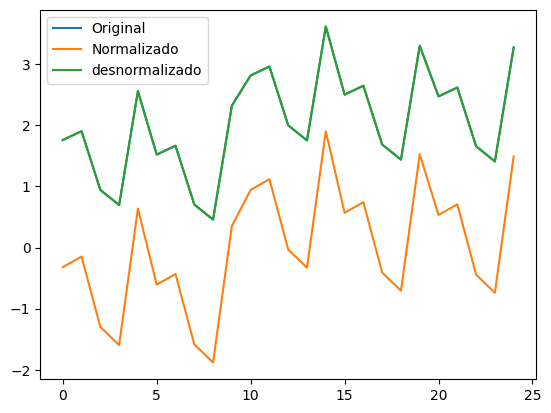

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import tf_levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.lm_model = lm.model.ModelWrapper(self.model)
        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.loss.MeanSquaredError()
        )

        return(self.lm_model)

2025-07-21 22:38:00.084915: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 22:38:00.135211: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 22:38:00.165730: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753137480.225768 1792804 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753137480.233833 1792804 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753137480.257876 1792804 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [5]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)

    def plot_loss_history(self):
      history = self.results.history
      
      plt.figure(figsize=(8, 5))
      plt.plot(history['loss'], label='Loss de Treinamento')
      plt.plot(history['val_loss'], label='Loss de Validação')
      plt.xlabel('Época')
      plt.ylabel('Loss')
      plt.title('Histórico de Loss')
      plt.legend()
      plt.grid(True)
      plt.tight_layout()
      plt.show()

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights("./content/models/initial-weights/initial-.weights.h5")
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
      
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [6]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"./content/models/{fileName}.weights.h5"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./content/models/initial-weights/initial-.weights.h5",
                f"./content/models/initial-weights/{fileName}.weights.h5")

  def SaveDataset(self, trainer, fileName):
    path = f"./content/dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be >= to acsending metrics
        #trainer.plot_loss_history()
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'./content/results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando Com amostras virtuais



In [ ]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=15)
tester.Loop(sort_by='r2_sup',
            boundarie = 0.5,
            hidden_sizes = [[12], [24], [36], [48], [60]],
            regularizers=[0.02, 0.2],
            learning_rate=[0.01, 0.1])

Testando combinacao1: Hidden Size=[4], regularizer=0.02, learning_rate=0.01


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


+++++++++++ [1_0] | 1 ++++++++++++++++++


Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  17
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_7,0.452353,0.504190,0.655407,0.326774,0.146910,0.294334,0.293504,0.046978,0.201099,0.383289,0.254268,0.389325,37.835868,74.800452
model_1_4_6,0.452279,0.504089,0.655505,0.327678,0.146930,0.294394,0.293420,0.046915,0.201101,0.383315,0.254167,0.389352,37.835596,74.800179
model_1_4_5,0.450814,0.501989,0.657006,0.344261,0.147323,0.295641,0.292142,0.045758,0.201186,0.383827,0.252172,0.389872,37.830254,74.794838
model_1_4_4,0.450686,0.501884,0.657129,0.345076,0.147357,0.295703,0.292038,0.045701,0.201186,0.383872,0.251998,0.389917,37.829788,74.794372
model_1_4_3,0.450567,0.501759,0.657231,0.345981,0.147389,0.295777,0.291950,0.045638,0.201189,0.383913,0.251836,0.389959,37.829356,74.793940
model_1_4_2,0.450444,0.501633,0.657340,0.346871,0.147422,0.295852,0.291857,0.045576,0.201192,0.383956,0.251668,0.390003,37.828907,74.793491
model_1_4_1,0.450400,0.501362,0.657300,0.348533,0.147434,0.296013,0.291891,0.045460,0.201221,0.383972,0.251608,0.390019,37.828747,74.793331
model_1_4_0,0.449887,0.500410,0.657516,0.354554,0.147572,0.296578,0.291708,0.045040,0.201294,0.384151,0.250910,0.390201,37.826883,74.791467


DataFrame salvo em ./content/results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Stopped at epoch:  15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Stopped at epoch:  22
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_0,0.451678,0.503541,0.656706,0.349682,0.147091,0.294719,0.292397,0.162169,0.200916,0.383525,0.253348,0.389565,37.833402,74.797986
model_1_5_3,0.445393,0.502384,0.657052,0.264771,0.148777,0.295406,0.292103,0.183343,0.200778,0.385717,0.244790,0.391791,37.810608,74.775191
model_1_5_1,0.446209,0.502346,0.656956,0.273289,0.148558,0.295429,0.292185,0.181219,0.200810,0.385433,0.245901,0.391503,37.813553,74.778137
model_1_5_2,0.445811,0.502304,0.656927,0.268870,0.148665,0.295454,0.292209,0.182321,0.200804,0.385571,0.245360,0.391644,37.812117,74.776701
model_1_5_4,0.444990,0.502042,0.657061,0.260525,0.148886,0.295609,0.292095,0.184402,0.200766,0.385857,0.244241,0.391934,37.809155,74.773739
model_1_5_5,0.442169,0.501390,0.656747,0.231139,0.149642,0.295997,0.292362,0.191729,0.200715,0.386836,0.240400,0.392928,37.799017,74.763600
model_1_5_6,0.440614,0.500985,0.656453,0.215507,0.150059,0.296237,0.292613,0.195628,0.200688,0.387375,0.238283,0.393476,37.793451,74.758034
model_1_5_7,0.440234,0.500884,0.656375,0.211737,0.150161,0.296297,0.292680,0.196568,0.200684,0.387507,0.237765,0.393609,37.792090,74.756674


DataFrame salvo em ./content/results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Stopped at epoch:  14
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_5,0.447458,0.518090,0.643036,0.102660,0.148223,0.286083,0.304041,0.137781,0.198899,0.384998,0.247602,0.391061,37.818069,74.782653
model_1_8_4,0.448461,0.513197,0.644113,0.119862,0.147954,0.288987,0.303124,0.135140,0.199375,0.384648,0.248968,0.390706,37.821702,74.786286
model_1_8_3,0.448626,0.510944,0.642954,0.128580,0.147910,0.290325,0.304110,0.133801,0.199553,0.384591,0.249192,0.390648,37.822301,74.786885
model_1_8_2,0.448582,0.508427,0.640795,0.137874,0.147922,0.291819,0.305949,0.132374,0.199725,0.384606,0.249133,0.390663,37.822144,74.786728
model_1_8_1,0.449510,0.506802,0.643621,0.146946,0.147673,0.292784,0.303542,0.130981,0.199983,0.384282,0.250397,0.390334,37.825511,74.790095
model_1_8_0,0.449790,0.503515,0.642366,0.160318,0.147598,0.294735,0.304612,0.128928,0.200279,0.384185,0.250778,0.390235,37.826529,74.791113


DataFrame salvo em ./content/results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  14
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  28
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_0,0.449985,0.514227,0.633500,0.555225,0.147545,0.288376,0.312163,0.137534,0.199767,0.384116,0.251044,0.390166,37.827238,74.791822
model_1_9_1,0.450239,0.511591,0.632448,0.552154,0.147477,0.289941,0.313059,0.138484,0.199894,0.384028,0.251389,0.390076,37.828161,74.792745
model_1_9_2,0.450474,0.510586,0.631359,0.549106,0.147414,0.290538,0.313986,0.139427,0.200022,0.383945,0.251710,0.389992,37.829019,74.793602


DataFrame salvo em ./content/results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
+++++++++++ [1_10] | 2 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [1_10] | 3 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
+++++++++++ [1_10] | 4 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
+++++++++++ [1_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_7,0.460746,0.534972,0.651732,0.059147,0.144659,0.276061,0.296634,0.193329,0.197166,0.380340,0.265697,0.386330,37.866757,74.831341
model_1_12_6,0.460250,0.533757,0.649208,0.067367,0.144792,0.276782,0.298784,0.191640,0.197389,0.380515,0.265021,0.386508,37.864917,74.829501
model_1_12_5,0.460067,0.533396,0.648239,0.070130,0.144841,0.276996,0.299610,0.191072,0.197483,0.380580,0.264772,0.386573,37.864238,74.828822
model_1_12_4,0.454454,0.523432,0.634907,0.109671,0.146347,0.282911,0.310964,0.182947,0.200051,0.382553,0.257129,0.388578,37.843555,74.808139
model_1_12_3,0.453824,0.521589,0.635200,0.109434,0.146516,0.284005,0.310715,0.182996,0.200269,0.382774,0.256271,0.388802,37.841246,74.805829
model_1_12_2,0.453000,0.519080,0.637255,0.115811,0.146737,0.285495,0.308965,0.181686,0.200560,0.383062,0.255149,0.389095,37.838233,74.802817
model_1_12_1,0.451711,0.512258,0.632474,0.135184,0.147083,0.289544,0.313037,0.177705,0.200907,0.383513,0.253393,0.389553,37.833523,74.798107
model_1_12_0,0.450770,0.507326,0.628539,0.152544,0.147335,0.292473,0.316389,0.174138,0.200894,0.383842,0.252113,0.389887,37.830095,74.794679


DataFrame salvo em ./content/results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
+++++++++++ [1_13] | 2 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
+++++++++++ [1_13] | 3 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
+++++++++++ [1_13] | 4 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [1_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_0,0.461510,0.533826,0.649802,0.629073,0.144454,0.276741,0.298278,0.126283,0.197152,0.380071,0.266737,0.386057,37.869590,74.834174
model_1_13_1,0.463134,0.530156,0.644827,0.618233,0.144018,0.278920,0.302516,0.129973,0.197105,0.379497,0.268948,0.385474,37.875632,74.840216
model_1_13_2,0.463601,0.528903,0.643032,0.614239,0.143893,0.279664,0.304045,0.131333,0.197088,0.379332,0.269584,0.385306,37.877371,74.841955
model_1_13_3,0.464464,0.526122,0.639024,0.605025,0.143661,0.281314,0.307458,0.134470,0.197037,0.379027,0.270759,0.384996,37.880593,74.845176
model_1_13_4,0.464566,0.525716,0.638473,0.603720,0.143634,0.281555,0.307928,0.134914,0.197029,0.378991,0.270898,0.384959,37.880974,74.845557
model_1_13_5,0.464663,0.525310,0.637928,0.602418,0.143608,0.281796,0.308392,0.135357,0.197019,0.378956,0.271031,0.384924,37.881337,74.845921
model_1_13_6,0.464757,0.524909,0.637390,0.601119,0.143583,0.282035,0.308850,0.135799,0.197009,0.378923,0.271159,0.384891,37.881688,74.846271
model_1_13_7,0.464847,0.524511,0.636856,0.599823,0.143559,0.282271,0.309304,0.136241,0.196998,0.378891,0.271281,0.384859,37.882022,74.846606
model_1_13_8,0.464933,0.524115,0.636330,0.598530,0.143536,0.282506,0.309753,0.136681,0.196987,0.378861,0.271398,0.384828,37.882345,74.846929
model_1_13_9,0.465690,0.520422,0.631424,0.585804,0.143332,0.284698,0.313931,0.141013,0.196822,0.378593,0.272429,0.384555,37.885177,74.849761


DataFrame salvo em ./content/results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
+++++++++++ [1_14] | 2 ++++++++++++++++++
Stopped at epoch:  16
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
+++++++++++ [1_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
+++++++++++ [1_14] | 4 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_14] | 5 ++++++++++++++++++
Stopped at epoch:  15
3/3 ━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_0,0.466193,0.521009,0.632493,0.372542,0.143198,0.284350,0.313021,0.162229,0.196922,0.378415,0.273114,0.384374,37.887059,74.851643
model_1_14_1,0.466031,0.520515,0.634343,0.346873,0.143241,0.284643,0.311445,0.168866,0.197096,0.378472,0.272893,0.384433,37.886453,74.851037
model_1_14_2,0.465956,0.520384,0.634460,0.344500,0.143261,0.284721,0.311345,0.169479,0.197117,0.378499,0.272791,0.384460,37.886172,74.850756
model_1_14_3,0.465680,0.518692,0.634792,0.337425,0.143335,0.285725,0.311063,0.171309,0.197183,0.378596,0.272415,0.384559,37.885139,74.849722
model_1_14_4,0.464298,0.516681,0.635767,0.314466,0.143706,0.286919,0.310233,0.177245,0.197410,0.379086,0.270533,0.385056,37.879973,74.844557
model_1_14_5,0.463572,0.516121,0.636075,0.305487,0.143901,0.287251,0.309970,0.179566,0.197508,0.379342,0.269545,0.385317,37.877264,74.841848
model_1_14_6,0.463378,0.516049,0.636145,0.303262,0.143953,0.287294,0.309910,0.180142,0.197532,0.379411,0.269280,0.385386,37.876540,74.841124
model_1_14_8,0.461210,0.515882,0.636753,0.281634,0.144534,0.287393,0.309392,0.185734,0.197790,0.380176,0.266329,0.386164,37.868479,74.833063
model_1_14_7,0.461442,0.515855,0.636701,0.283742,0.144472,0.287409,0.309437,0.185188,0.197758,0.380095,0.266645,0.386081,37.869340,74.833923
model_1_14_9,0.459782,0.514877,0.637075,0.269377,0.144917,0.287990,0.309118,0.188903,0.198024,0.380680,0.264383,0.386676,37.863182,74.827766


DataFrame salvo em ./content/results/metrics_1_14
Testando combinacao2: Hidden Size=[4], regularizer=0.02, learning_rate=0.1


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


+++++++++++ [2_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0